In [1]:
import numpy as np
import cv2
import dlib
from imutils import face_utils
import matplotlib.pyplot as plt
from statistics import mean
from collections import deque
import time

In [2]:
detector = cv2.CascadeClassifier("../haarcascade_frontalface_default.xml")

In [3]:
dim = (400,640)
EAR_Values = list()

In [4]:
def __draw_label(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.4
    color = (255, 255, 255)
    thickness = cv2.FILLED
    margin = 2
    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 1, cv2.LINE_AA)

In [5]:
def compute(ptA, ptB):
    dist = np.linalg.norm(ptA - ptB)
    return dist


def EAR(a, b, c, d, e, f):
    up = compute(b, d) + compute(c, e)
    down = compute(a, f)
    ratio = up / (2.0 * down)

    return ratio

In [6]:
flag= True
cap = cv2.VideoCapture(0)
eff_EAR = 0.25
startTime = 0
endTime = 0

eye_state = deque()
eye_state_sum = {"Open":0,"Semi-open":0,"Close":0}

while(flag):
    ret, frame = cap.read()
    if ret == True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector.detectMultiScale(frame,1.3,5)
        if(len(faces)):
            x,y,w,h = faces[0]
            flag=False
            track_window = (x, y, w, h)
            roi = frame[y:y+h, x:x+w]
            hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
            roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
            cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
            term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
            
            i = 0
            startTime = time.time()
            while(True):
                ret, frame = cap.read()

                if ret == True:
                    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
                    dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
                    
                    ret, track_window = cv2.CamShift(dst, track_window, term_crit)

                    #print(ret,track_window)
                    pts = cv2.boxPoints(ret)
                    #print("points",pts)
                    pts = np.int0(pts)
                    #print("after np int",pts)
                    copy_frame = frame.copy()
                    img2 = cv2.polylines(copy_frame,[pts],True, 255,2)
                    #img = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                    cv2.imshow('Frame',img2)
                    
                    frame_pts = cv2.boundingRect(pts)
                    x,y,w,h = frame_pts
                    new_frame = frame[y:y+h, x:x+w].copy()
                    
                    #resizedFrame = cv2.resize(new_frame, dim, interpolation = cv2.INTER_AREA)
                    #__draw_label(resizedFrame, text, (20,20), (0,0,0))
                    #cv2.imshow('Face Frame', new_frame)
                    
                    dlib_detector = dlib.get_frontal_face_detector()
                    dlib_predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")
                    
                    if(i<80): 
                        gray_new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
                        
                        faces = dlib_detector(gray_new_frame)
                        
                        if(len(faces)):
                            i=i+1
                            landmarks = dlib_predictor(gray_new_frame, faces[0])
                            landmarks = face_utils.shape_to_np(landmarks)
                            left_blink = EAR(landmarks[36], landmarks[37],landmarks[38], landmarks[41], landmarks[40], landmarks[39])
                            right_blink = EAR(landmarks[42], landmarks[43],landmarks[44], landmarks[47], landmarks[46], landmarks[45])

                            EAR_Values.append((left_blink+right_blink)/2)

                            for n in range(0, 68):
                                (x1, y1) = landmarks[n]
                                cv2.circle(copy_frame, (x+x1, y+y1), 1, (255, 255, 255), -1) 

                            __draw_label(copy_frame, "Computing EAR", (20,20), (0,0,0))
                            cv2.imshow('EAR Calculation Frame', copy_frame)
                    elif(i==80):
                        eff_EAR = round(mean(EAR_Values),2)-0.02
                        i=i+1
                        endTime = time.time()
                    else:
                        gray_new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
                        
                        faces = dlib_detector(gray_new_frame)
                        
                        if(len(faces)):
                            #i=i+1
                            landmarks = dlib_predictor(gray_new_frame, faces[0])
                            landmarks = face_utils.shape_to_np(landmarks)
                            left_blink = EAR(landmarks[36], landmarks[37],landmarks[38], landmarks[41], landmarks[40], landmarks[39])
                            right_blink = EAR(landmarks[42], landmarks[43],landmarks[44], landmarks[47], landmarks[46], landmarks[45])

                            EAR_val = (left_blink+right_blink)/2
                            
                            if(EAR_val>=eff_EAR):
                                eye_state.append(2)
                                eye_state_sum["Open"]+=1
                                print("open")
                            #elif(EAR_val<eff_EAR and EAR_val):
                            elif(EAR_val>=(eff_EAR*0.8)):
                                eye_state.append(1)
                                eye_state_sum['Semi-open']+=1
                                print("Semi-close")
                            else:
                                eye_state.append(0)
                                eye_state_sum['Close']+=1
                                print("Close")
                                
                            if(len(eye_state)>20):
                                last_state = eye_state.popleft()
                                if(last_state==0):
                                    eye_state_sum['Close']-=1
                                elif(last_state==1):
                                    eye_state_sum['Semi-open']-=1
                                else:
                                    eye_state_sum['Open']-=1
                                print(eye_state_sum)

                            for n in range(0, 68):
                                (x1, y1) = landmarks[n]
                                cv2.circle(copy_frame, (x+x1, y+y1), 1, (255, 255, 255), -1) 

                            __draw_label(copy_frame, "Effective EAR: "+str(eff_EAR), (20,20), (0,0,0))
                            cv2.imshow('Final Frame', copy_frame)
                        

                    k = cv2.waitKey(30) & 0xff
                    if k == 27:
                        break
                else:
                    break
cap.release()
cv2.destroyAllWindows()

open
Semi-close
open
Semi-close
Semi-close
Semi-close
Semi-close
open
Semi-close
Semi-close
open
open
open
open
open
open
open
open
open
open
{'Open': 12, 'Semi-open': 7, 'Close': 0}
open
{'Open': 13, 'Semi-open': 6, 'Close': 0}
Semi-close
{'Open': 12, 'Semi-open': 7, 'Close': 0}
Close
{'Open': 12, 'Semi-open': 6, 'Close': 1}
Semi-close
{'Open': 12, 'Semi-open': 6, 'Close': 1}
open
{'Open': 13, 'Semi-open': 5, 'Close': 1}
Close
{'Open': 13, 'Semi-open': 4, 'Close': 2}
Close
{'Open': 12, 'Semi-open': 4, 'Close': 3}
Semi-close
{'Open': 12, 'Semi-open': 4, 'Close': 3}
Semi-close
{'Open': 12, 'Semi-open': 4, 'Close': 3}
open
{'Open': 12, 'Semi-open': 4, 'Close': 3}
open
{'Open': 12, 'Semi-open': 4, 'Close': 3}
open
{'Open': 12, 'Semi-open': 4, 'Close': 3}
open
{'Open': 12, 'Semi-open': 4, 'Close': 3}
open
{'Open': 12, 'Semi-open': 4, 'Close': 3}


In [7]:
len(EAR_Values)

80

In [8]:
eff_EAR

0.22

In [9]:
EAR_Thres = mean(EAR_Values)
EAR_Thres

0.24177482277490522

In [10]:
print(round(EAR_Thres,2))

0.24


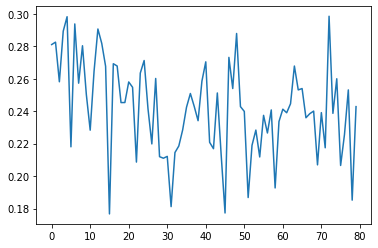

In [11]:
plt.plot(EAR_Values)

In [12]:
total = round(endTime-startTime)
print("Total time taken in Seconds: ", total)
print("FPS: ",float(81/total))

Total time taken in Seconds:  450
FPS:  0.18
